In [8]:
%pip install tensorflow

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

Note: you may need to restart the kernel to use updated packages.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Print more detailed GPU information
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Name:", gpu.name)
        print("Device details:", tf.config.experimental.get_device_details(gpu))
    
    # Test GPU with a simple operation
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c = tf.matmul(a, b)
        print("Matrix multiplication result:", c)
        print("Tensor placed on:", c.device)
else:
    print("No GPU devices found")

# Also check TensorFlow version
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
Name: /physical_device:GPU:0
Device details: {'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU'}
Matrix multiplication result: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Tensor placed on: /job:localhost/replica:0/task:0/device:GPU:0
TensorFlow version: 2.19.0


I0000 00:00:1745825863.391606 1057575 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3600 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


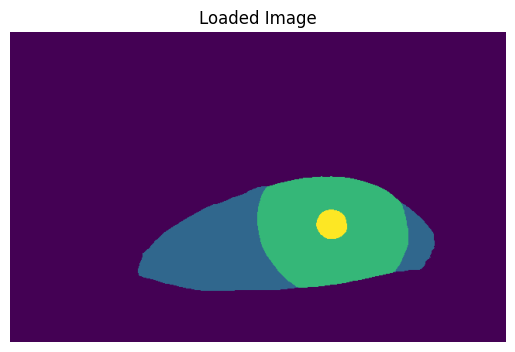

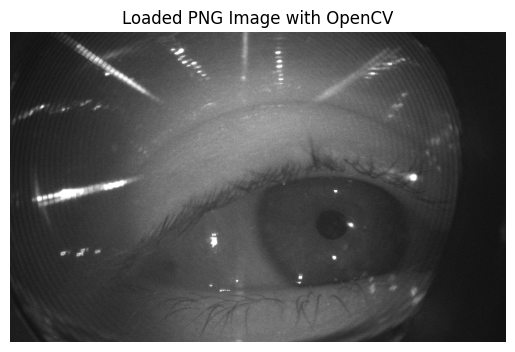

In [11]:
# Load the .npy file
label_file_path = '/home/yasas/GazeEstimation/openEDS/openEDS/test/labels/000010.npy'
image_file_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/test/images/000010.png'

image_label = np.load(label_file_path)

# Display the image
plt.imshow(image_label)  # or remove cmap='gray' for a color image if applicable
plt.title('Loaded Image')
plt.axis('off')  # Optional: Turns off the axis
plt.show()

img = cv2.imread(image_file_path)

# OpenCV loads images in BGR format by default, so we convert it to RGB for correct display
img_rgb = cv2.cvtColor(img, cv2.IMREAD_COLOR)

# Display the image using matplotlib
plt.imshow(img_rgb)
plt.title('Loaded PNG Image with OpenCV')
plt.axis('off')  # Optional: Turns off the axis
plt.show()

In [12]:
def load_images_label_pairs(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))  # Sort to maintain consistency
    label_files = sorted(os.listdir(label_dir))

    images =[]
    labels=[]

    currupted_images = [2355, 2365, 2366]
    print("Images count: " + str(len(image_files)))
    count = 0
    for img, label in zip(image_files, label_files):
        count += 1
        if(count in currupted_images):
            continue
        img_path = os.path.join(image_dir, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Adjust if images are colored
        img = cv2.resize(img, (128, 128))  # Resize if needed
        images.append(img)


        label_path = os.path.join(label_dir, label)
        label = np.load(label_path)
        label = cv2.resize(label, (128, 128))  # Resize to match the image size
        labels.append(label)


    return np.array(images), np.array(labels)


In [5]:
image_dir_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/test/images'
label_dir_path = '/home/yasas/GazeEstimation/openEDS/openEDS/test/labels'
images, labels = load_images_label_pairs(image_dir_path, label_dir_path)

# # Normalize the images and labels
images = images / 255.0  # Normalize images between [0, 1]
labels = labels / np.max(labels)  # Normalize labels between [0, 1]

Images count: 2744


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


# Print the shapes of the resulting datasets
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing images shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")



Training images shape: (2192, 128, 128)
Training labels shape: (2192, 128, 128)
Testing images shape: (549, 128, 128)
Testing labels shape: (549, 128, 128)


In [8]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    
    # Decoder
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the U-Net model
unet = unet_model(input_size=(128, 128, 1))
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │    131,200 │ conv2d_8[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 128, 128,  │     32,832 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │         65 │ batch_normalizat

 Total params: 904,129 (3.45 MB)

 Trainable params: 903,361 (3.45 MB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
history = unet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # You can adjust the number of epochs
    batch_size=4,  # You can adjust the batch size
    shuffle=True
)

# Save the trained model
unet.save('unet_gaze_estimation_model.h5')

Epoch 1/50


I0000 00:00:1745825983.148521 1057822 service.cc:152] XLA service 0x7f6470017060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745825983.148576 1057822 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-28 13:09:43.239690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745825983.812194 1057822 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/548 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.4099 - loss: 0.8520 

I0000 00:00:1745825990.878137 1057822 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


548/548 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.8110 - loss: 0.3305 - val_accuracy: 0.8602 - val_loss: 0.1568
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8618 - loss: 0.1038 - val_accuracy: 0.8621 - val_loss: 0.1334
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8614 - loss: 0.0978 - val_accuracy: 0.8620 - val_loss: 0.0965
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.8610 - loss: 0.0957 - val_accuracy: 0.8622 - val_loss: 0.1055
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.8609 - loss: 0.0943 - val_accuracy: 0.8622 - val_loss: 0.1040
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.8620 - loss: 0.0928 - val_accuracy: 0.8618 - val_loss: 0.1072
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8617 - loss: 0.0923 - val_accuracy: 0.8622 - val_loss: 0.0979
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.8610 - loss: 0.0924 - val_accurac

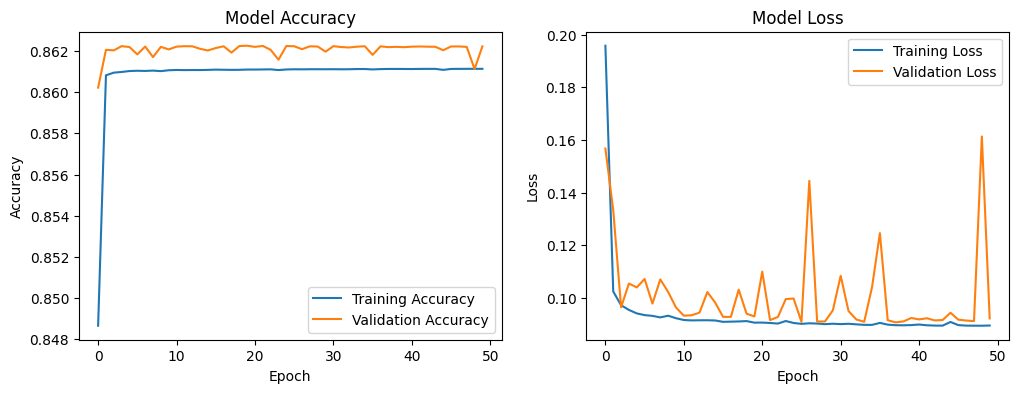

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


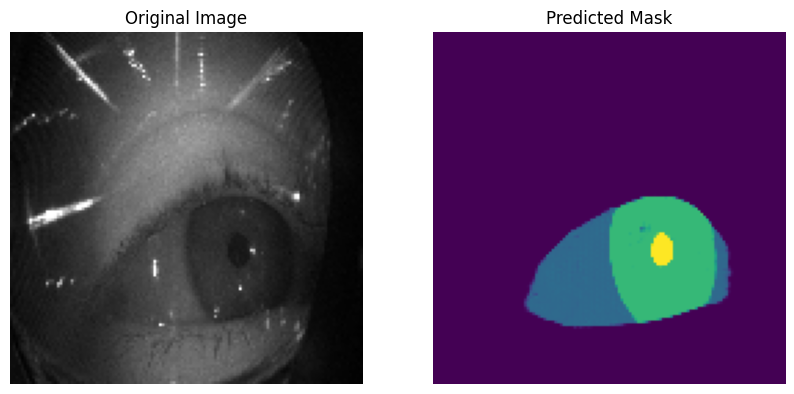

In [9]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained U-Net model
model = tf.keras.models.load_model('unet_gaze_estimation_model.h5')

# Define the path to the image you want to predict
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/test/images/000000.png'

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale image

# Resize the image to the size expected by the model (e.g., 256x256)
image_resized = cv2.resize(image, (128, 128))

# Normalize the image to the [0, 1] range
image_normalized = image_resized/255

# Add a batch dimension and a channel dimension (required for model input)
input_image = np.expand_dims(image_normalized, axis=0)  # Shape: (1, 256, 256)
input_image = np.expand_dims(input_image, axis=-1)  # Shape: (1, 256, 256, 1)

# Predict the output using the model
predicted_mask = model.predict(input_image)

# Remove batch dimension to get the mask image
predicted_mask = predicted_mask[0, :, :, 0]  # Shape: (256, 256)

# Apply a threshold to convert the mask to binary (0 and 1) if needed
#predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Display the original image and the predicted mask side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_resized, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='viridis')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


In [10]:

# Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Lightweight U-Net Model
def lightweight_unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)

    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
light_unet = lightweight_unet_model(input_size=(128, 128, 1))
light_unet.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

# Print training set size
print(f"Training samples: {len(X_train)}")

# Train the model
history = light_unet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # <-- Fixed here
    epochs=50,
    batch_size=4,
    callbacks=[early_stopping, lr_scheduler],
    shuffle=True
)

# Save the model
light_unet.save('light_weight_unet_gaze_estimation_model.h5')  # <-- Typo fixed


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 64, 64,    │     32,832 │ conv2d_20[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,792 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 128, 128,  │      8,224 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     18,464 │ concatenate_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │         33 │ batch_normalizat

 Total params: 226,785 (885.88 KB)

 Trainable params: 226,401 (884.38 KB)

 Non-trainable params: 384 (1.50 KB)

Training samples: 2192
Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8037 - loss: 0.3667 - val_accuracy: 0.8578 - val_loss: 0.1462 - learning_rate: 0.0010
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8620 - loss: 0.1078 - val_accuracy: 0.8557 - val_loss: 0.1580 - learning_rate: 0.0010
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8618 - loss: 0.0997 - val_accuracy: 0.8603 - val_loss: 0.1215 - learning_rate: 0.0010
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8600 - loss: 0.0981 - val_accuracy: 0.8620 - val_loss: 0.1147 - learning_rate: 0.0010
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8607 - loss: 0.0965 - val_accuracy: 0.8614 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8611 - loss: 0.0952 - val_accuracy: 0.8606 - val_loss: 0.1081 - learning_rate: 0.0010
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - acc

I0000 00:00:1745908421.501872 1175514 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3600 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1745908422.666683 1175855 service.cc:152] XLA service 0x7f0cd000af00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745908422.666727 1175855 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-29 12:03:42.677341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745908422.739294 1175855 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1745908424.038920 1175855 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


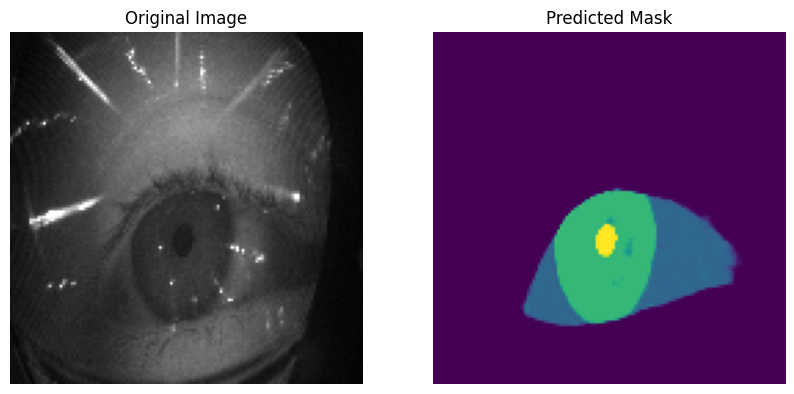

In [3]:
# Re-define dice_loss again (important!)
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Now load the model properly
model = load_model('light_weight_unet_gaze_estimation_model.h5', custom_objects={'dice_loss': dice_loss})


# Define the path to the image you want to predict
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/test/images/000100.png'

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale image

# Resize the image to the size expected by the model (e.g., 256x256)
image_resized = cv2.resize(image, (128, 128))

# Normalize the image to the [0, 1] range
image_normalized = image_resized/255

# # Add a batch dimension and a channel dimension (required for model input)
input_image = np.expand_dims(image_normalized, axis=0)  # Shape: (1, 256, 256)
input_image = np.expand_dims(input_image, axis=-1)  # Shape: (1, 256, 256, 1)

# Predict the output using the model
predicted_mask = model.predict(input_image)

# Remove batch dimension to get the mask image
predicted_mask = predicted_mask[0, :, :, 0]  # Shape: (256, 256)

# Apply a threshold to convert the mask to binary (0 and 1) if needed
#predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Display the original image and the predicted mask side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_resized, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='viridis')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

def calculate_gaze_vector_image(image_path, model):
    image_save_prefix = image_path.split('/')[-1].split('.')[0]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize and normalize
    image_resized = cv2.resize(image, (128, 128))
    image_normalized = image_resized / 255.0

    # Prepare input for model
    input_image = np.expand_dims(image_normalized, axis=0)  # (1, 128, 128)
    input_image = np.expand_dims(input_image, axis=-1)      # (1, 128, 128, 1)

    # Display the mask with circles
    # plt.figure(figsize=(8, 8))
    # plt.imshow(image_resized)
    # plt.title('Predicted Mask with Circles')
    # plt.axis('off')
    # plt.show()


    # Predict mask
    predicted_mask =  model.predict(input_image)[0, :, :, 0]  # (128, 128)

    plt.figure(figsize=(8, 8))
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask with Circles')
    plt.axis('off')
    plt.show()

    #scalar region
    scalar_lower_bound = 0.2
    scalar_upper_bound = 0.5
    scalar_region_mask = np.logical_and(predicted_mask >= scalar_lower_bound, predicted_mask <= scalar_upper_bound).astype(np.uint8)

    iris_lower_bound = 0.75
    iris_upper_bound = 1
    iris_region_mask = np.logical_and(predicted_mask >= iris_lower_bound, predicted_mask <= iris_upper_bound).astype(np.uint8)

    # Find contours from the binary mask
    unfiltered_scalar_contours, _ = cv2.findContours(scalar_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    iris_contours, _ = cv2.findContours(iris_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(iris_contours) == 0:
        print("No iris contours found.")
        return None

    scalar_contours = [cnt for cnt in unfiltered_scalar_contours if cv2.contourArea(cnt) > 25]

    # Find the iris contour with the largest area
    largest_iris_contour = max(iris_contours, key=cv2.contourArea)

    M = cv2.moments(largest_iris_contour)

    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        # fallback if the area is too small
        center_x, center_y = 0, 0

    iris_center = (center_x, center_y)

    # Initialize leftmost and rightmost points
    leftmost = (128, 128)
    rightmost = (0, 0)

    # Find extreme points from all contours
    for contour in scalar_contours:
        for point in contour:
            x, y = point[0]
            if x < leftmost[0]:
                leftmost = (x, y)
            if x > rightmost[0]:
                rightmost = (x, y)

    print(f"Leftmost Point: {leftmost}")
    print(f"Rightmost Point: {rightmost}")

    scelar_vector =  np.array(rightmost) - np.array(leftmost)
    middle_point = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    # Convert predicted mask to RGB to draw colored circles
    predicted_mask_rgb = cv2.cvtColor((predicted_mask * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Draw circles at leftmost and rightmost points
    cv2.circle(predicted_mask_rgb, leftmost, radius=2, color=(255, 0, 0), thickness=-1)  # Blue circle
    cv2.circle(predicted_mask_rgb, rightmost, radius=2, color=(0, 0, 255), thickness=-1) # Red circle
    cv2.circle(predicted_mask_rgb, iris_center, radius=2, color=(0, 255, 255), thickness=-1) # Red circle
    cv2.circle(predicted_mask_rgb, middle_point, radius=2, color=(225, 0, 255), thickness=-1)  # Magenta circle
    cv2.line(predicted_mask_rgb, leftmost, rightmost, color=(0, 255, 0), thickness=1)
    cv2.arrowedLine(predicted_mask_rgb, middle_point, iris_center, color=(255, 0, 0), thickness=1, tipLength=0.1)

    # Display the mask with circles
    plt.figure(figsize=(8, 8))
    plt.imshow(predicted_mask_rgb)
    plt.title('Predicted Mask with Circles')
    plt.axis('off')
    plt.show()

    # Create the directory if it doesn't exist
    output_dir = "gaze_vector_prediction"
    os.makedirs(output_dir, exist_ok=True)

    # Define the output file path
    output_file_path = os.path.join(output_dir, image_save_prefix+"_vectors.png")

    # Save the image
    cv2.imwrite(output_file_path, cv2.cvtColor(predicted_mask_rgb, cv2.COLOR_RGB2BGR))
    print(f"Image saved to {output_file_path}")

2025-04-29 12:32:35.547559: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 12:32:35.595374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745910155.626018 1184388 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745910155.634934 1184388 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745910156.160174 1184388 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# Re-define dice_loss (necessary for custom_objects when loading model)
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Load model
model = load_model('light_weight_unet_gaze_estimation_model.h5', custom_objects={'dice_loss': dice_loss})

# Load the image
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/test/images/000110.png'


image_dir_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/test/images'
image_files = sorted(os.listdir(image_dir_path)) 

for image_file in image_files:
    image_path = os.path.join(image_dir_path, image_file)
    calculate_gaze_vector_image(image_path, model)

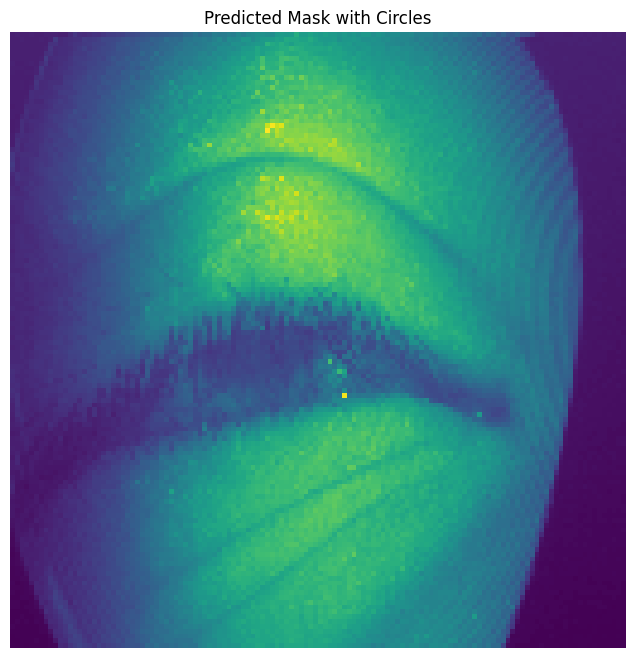

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


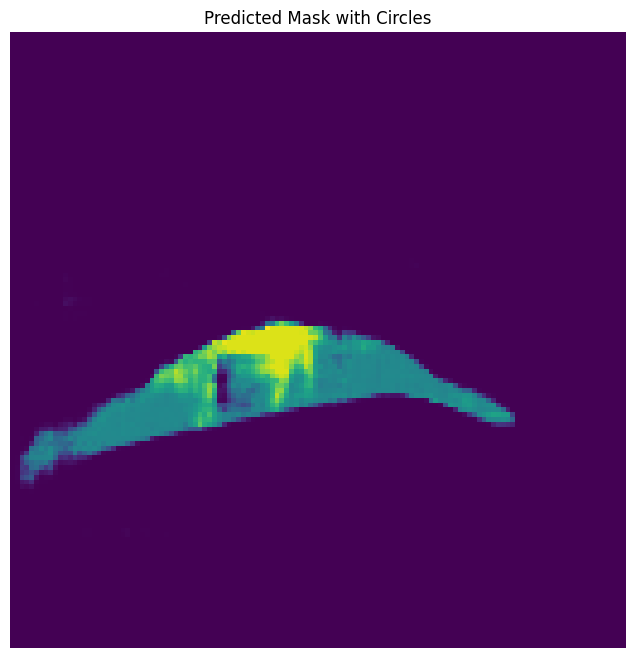

No iris contours found.


In [9]:
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/test/images/002100.png'

calculate_gaze_vector_image(image_path, model)